 # Simulation based on the Dataset of the ACN in 2019 using OpenDSS

## 1. Lines' properties estimation

There are five levels of current in the ACN infrastructure, that's why five types of lines are required.

The properties needed for OpenDSS in order to perform the simulation are:
- DIAM: diameter
- RAC: resistance in alternatif current
- Runits: unit of resistance in alternatif current (ft, m, etc per Ohm)
- radunits: unit of the diameter
- Normamps: normal ampicity

From the level of the current and the length of each type of line, we will use an online calculator to know these properties.

The online calculator is available in here: https://www.jcalc.net/cable-sizing-calculator-as3008

### 1.1. Properties of type 1 lines

Amps = 260 A\
Length = 10 m

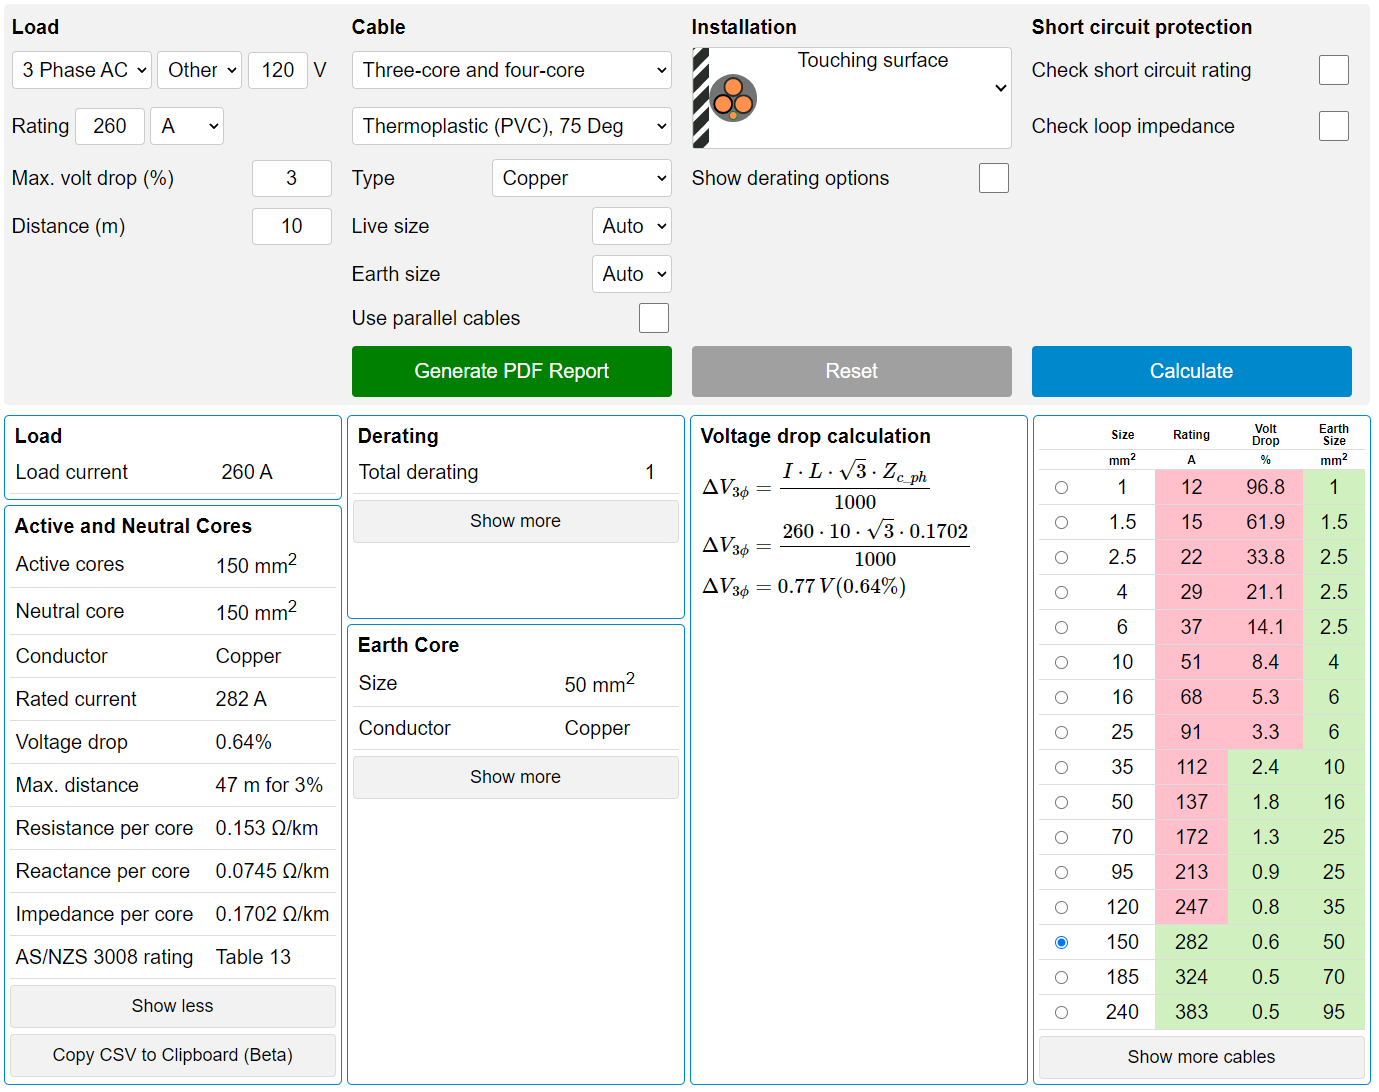

In [6]:
A = 150
d = 2 * math.sqrt(A / math.pi) / 10
print("DIAM =", f"{d:0.3}", "cm")

DIAM = 1.38 cm


### 1.2. Properties of type 2 lines

Amps = 130 A\
Length = 5 m

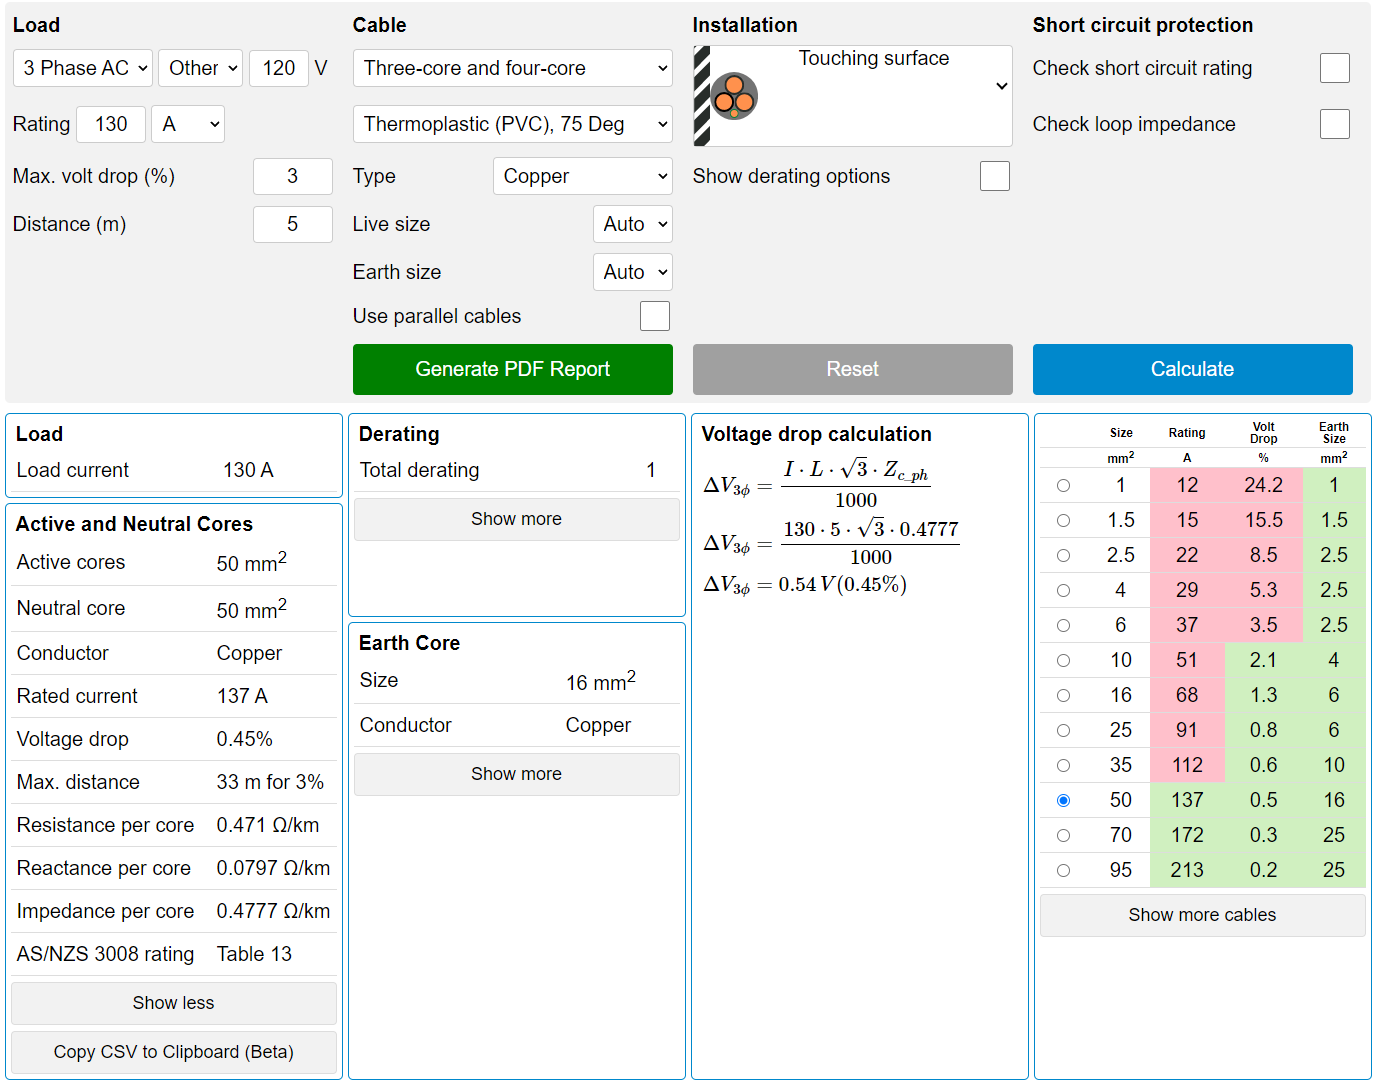

In [165]:
A = 50
d = 2 * math.sqrt(A / math.pi) / 10
print("DIAM =", f"{d:0.3}", "cm")

DIAM = 0.798 cm


### 1.3. Properties of type 3 lines 

Amps = 80 A\
Length = 10 m

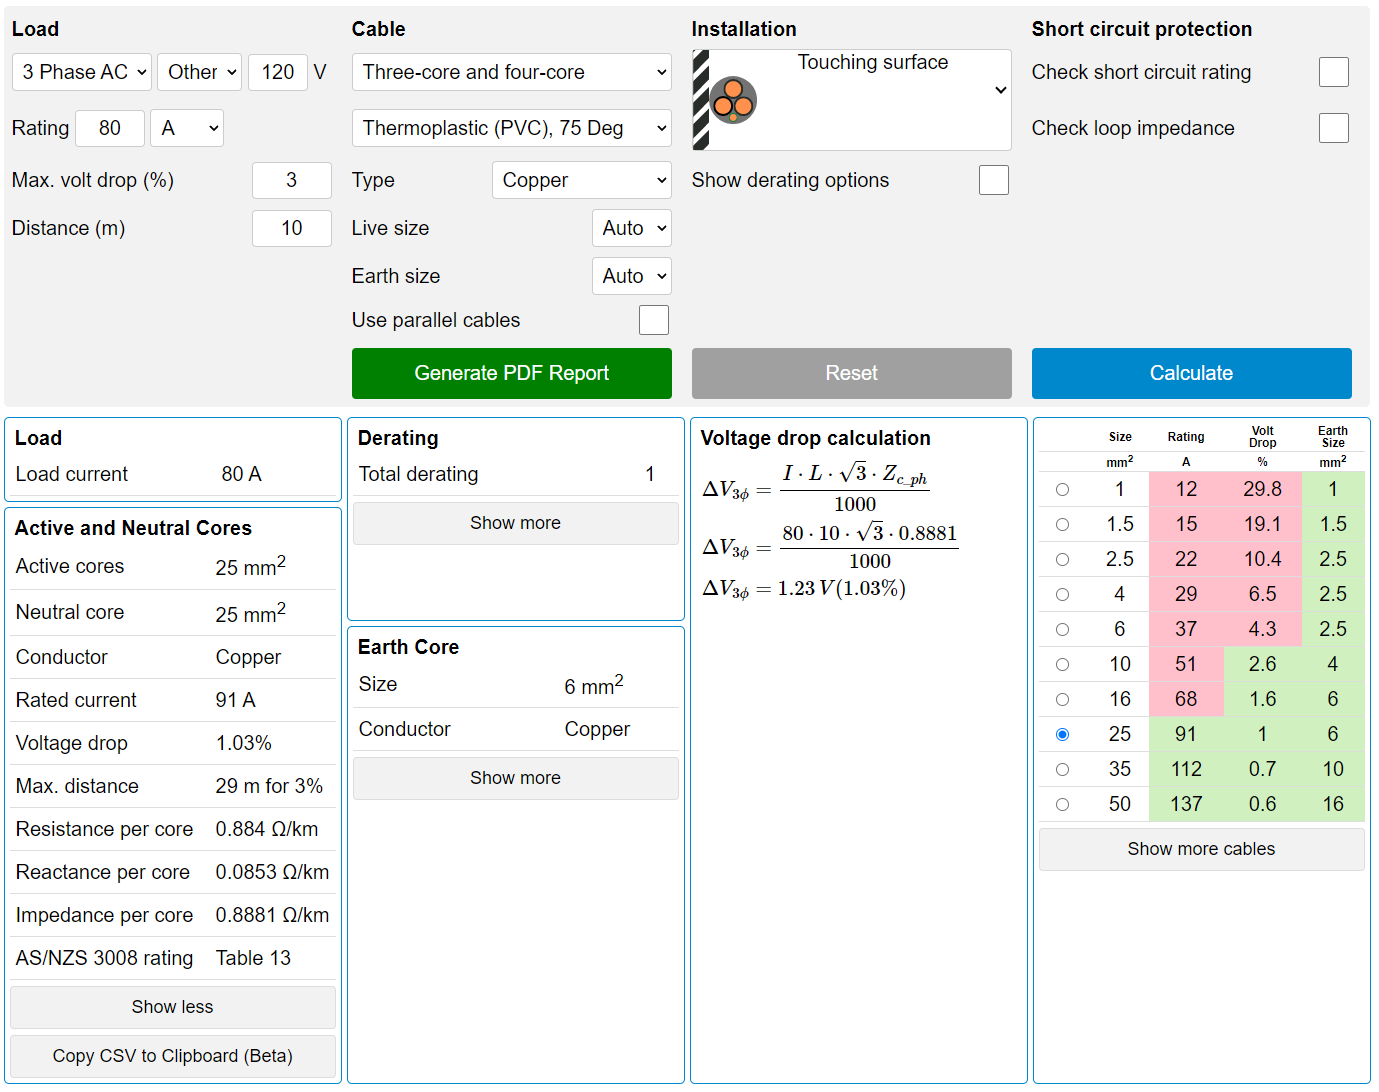

In [166]:
A = 25
d = 2 * math.sqrt(A / math.pi) / 10
print("DIAM =", f"{d:0.3}", "cm")

DIAM = 0.564 cm


### 1.4. Properties of type 4 lines 

Amps = 65 A\
Length = 5 m

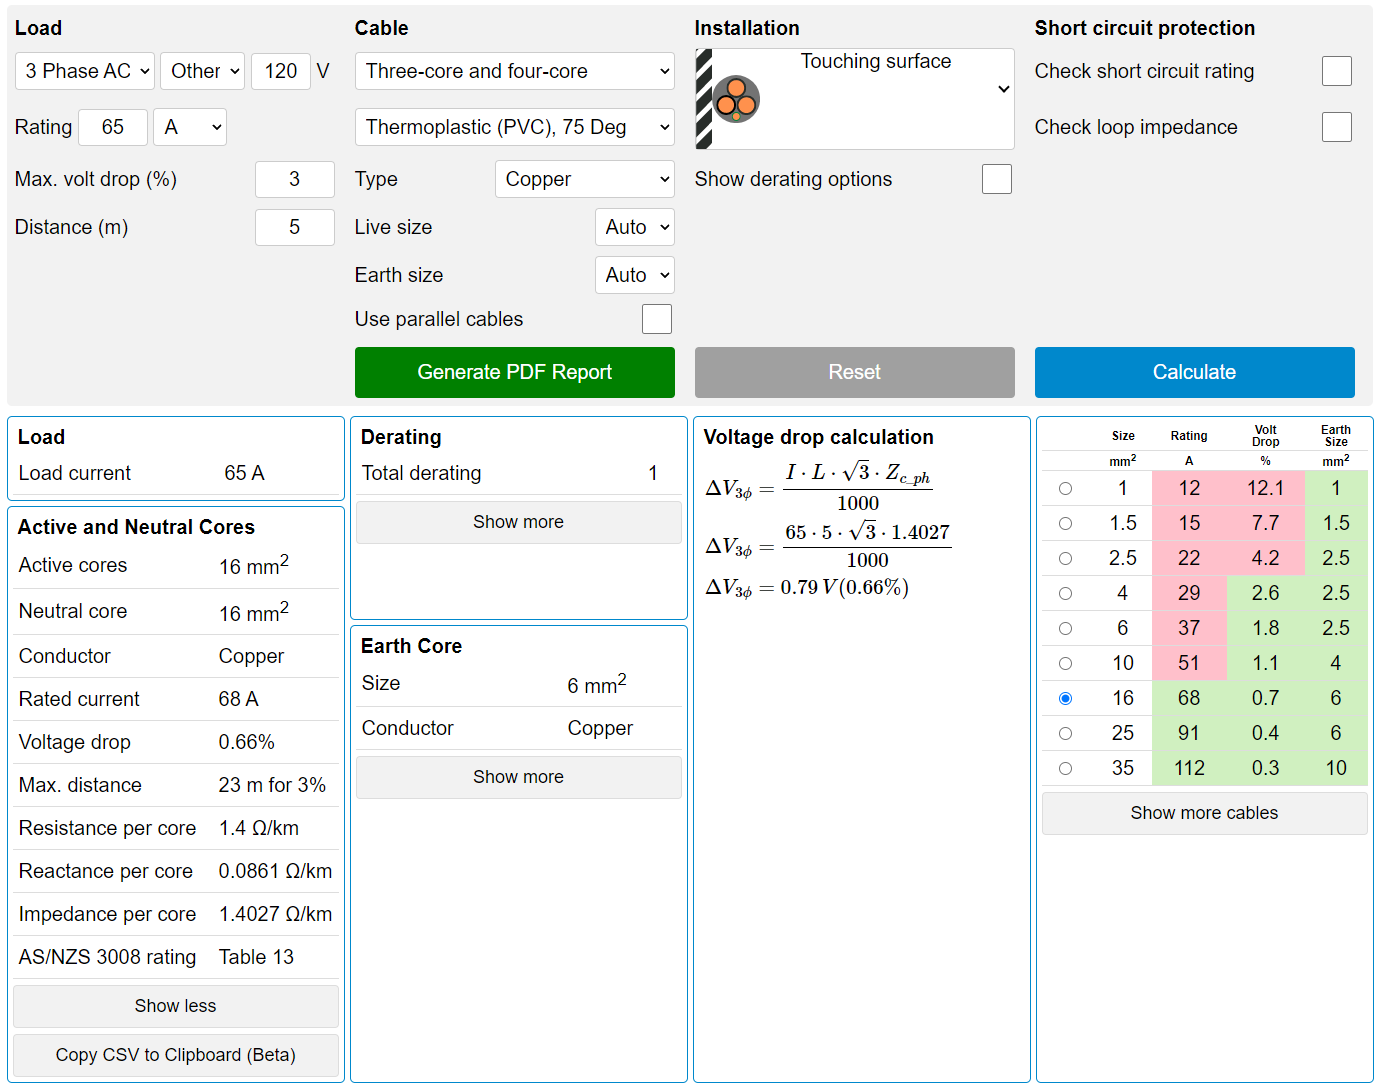

In [167]:
A = 16
d = 2 * math.sqrt(A / math.pi) / 10
print("DIAM =", f"{d:0.3}", "cm")

DIAM = 0.451 cm


### 1.5. Properties of type 5 lines

Amps = 55.4 A\
Length = 0.5 m

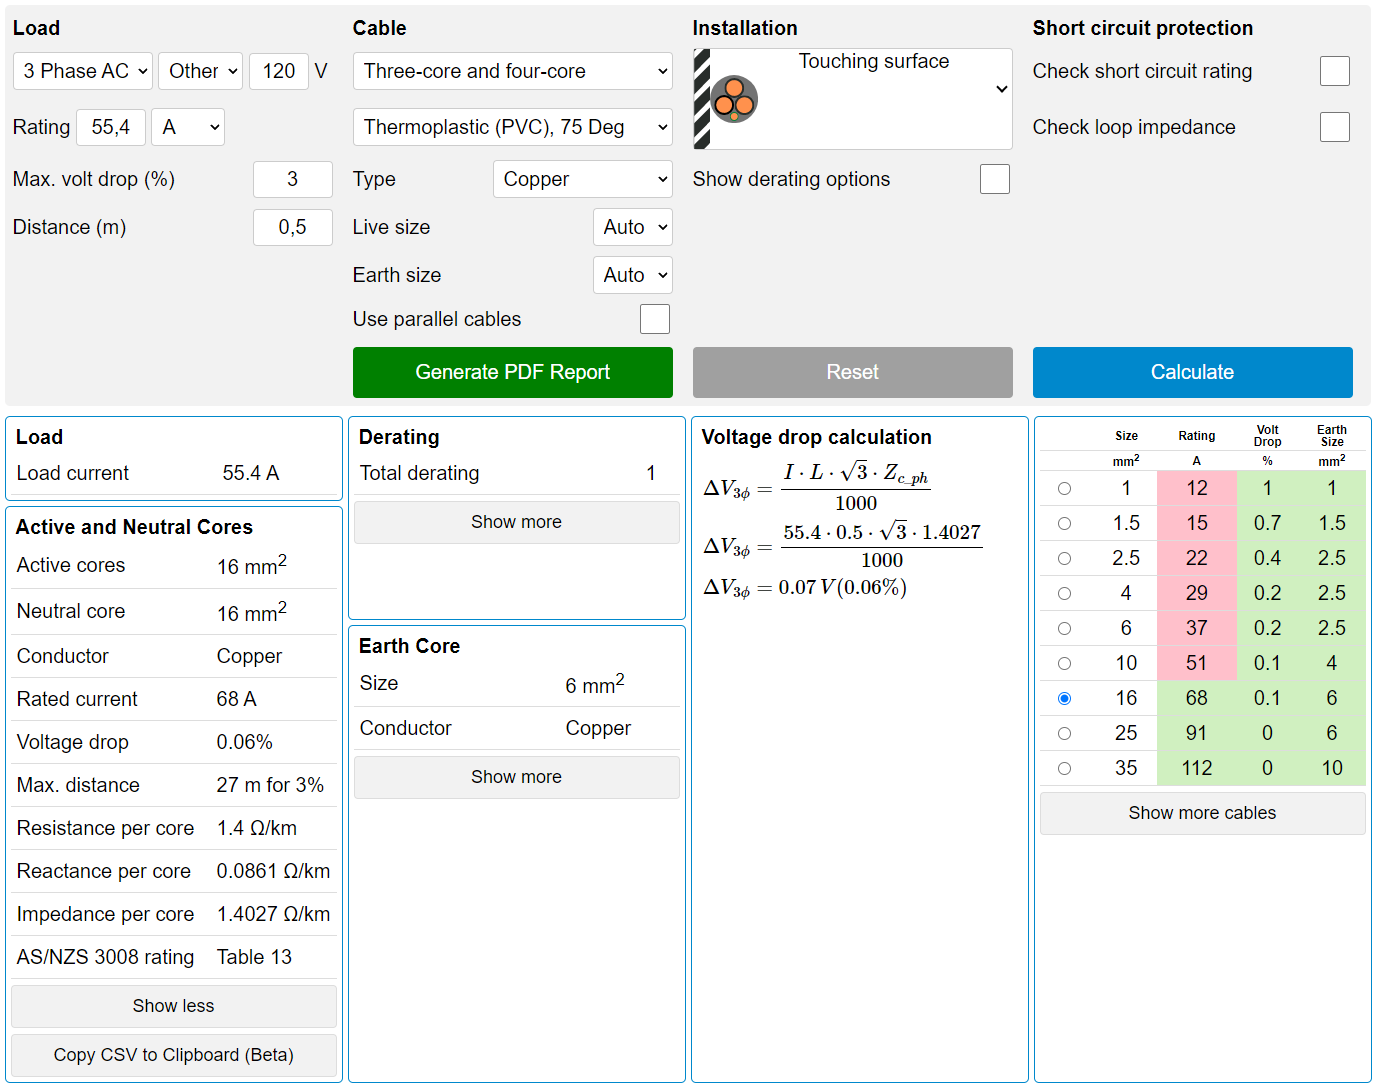

In [168]:
A = 16
d = 2 * math.sqrt(A / math.pi) / 10
print("DIAM =", f"{d:0.3}", "cm")

DIAM = 0.451 cm


## 2. Simulation

### 2.1 Importing the necessary libraries

In [2]:
import win32com.client
dssObj = win32com.client.Dispatch("OpenDSSEngine.DSS")
dssText = dssObj.Text
dssCircuit = dssObj.ActiveCircuit
dssSolution = dssCircuit.Solution
dssElem = dssCircuit.ActiveCktElement
dssBus = dssCircuit.ActiveBus
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import datetime as dt
import math
import cmath
import numpy as np
from tqdm import tqdm

### 2.2 Compile the Master.DSS file for one time to activate Python interfacing 

In [4]:
dssText.Command = "compile 'C:/Users/lazhe/OneDrive/Thesis/OpenDSS/OpenDSS_simulations/1_Yearly_simulation_with_lines_losses/Master.DSS'"

### 2.3 Loading the Dataset to a dicionary called "data"

In [5]:
file_list = os.listdir("Dataset")
data = {}
for file in file_list:
    file_pd = pd.read_csv("Dataset/" + file)
    data[file[3:9].lower()] = file_pd["Power"]

### 2.4 Running the simulation 

The simulation is done with a 10 minutes timestamp for the whole year of 2019, so the total number of simulation number is 52560 points.

P.S. 1: The OpenDSS simulatin using Python interfacing is a bit different than using only OpenDSS. Using only OpenDSS, the whole Dataset is fed to OpenDSS and we set the mode to yearly simulation and fix the timestamp and the total number of the time serie. In the case of Python interfacing, OpenDSS is called by a Python script to run a "Snap mode" simulation (simulation of a fixed values of the load power), then we change the values of the load power each timestamp depending on the Dataset. That's why the is a main loop that iterate over the Dataset to change the values and run a "Snap mode" simulation with OpenDSS every timestamp.

P.S. 2: You can skip the simulation and play around directly with the results, because they are already saved in a csv file and the simulation takes around 55 minutes (in my computer) to be done.

In [6]:
result = pd.DataFrame()                                                    #Initialize the result DataFrame 
losses = pd.DataFrame()                                                    #Initialize the losses DataFrame
voltages = pd.DataFrame()                                                  #Initialize the voltages DataFrame 
n_sim_pt = data["ca-148"].shape[0]                                         #Number of simulation points
loop = tqdm(total=n_sim_pt, position=0, leave=False)
for i in range(n_sim_pt):                                                  #The main for loop that iterate over the total simulation point
    loop.set_description("Running simulation...".format(i))
    loop.update(1)
    for station in data:                                                   #for loop that that iterates over the  stations
        station_kW = str(float(data[station][i]) * 0.001)                  #Convert the power from W to kW
        dssText.Command = 'Edit "Load.' + station + '" kW=' + station_kW   #Change the power of the station "station" to its new value "station_kW"
    dssSolution.Solve()                                                    #Run a Snap mode simulation
    dssText.Command = 'Export p_byphase'                                   #Export the powers per phase to a csv file to be used later
    dssText.Command = 'Export losses'                                      #Export lines losses to a csv file to be used later
    dssText.Command = 'Export ElemVoltages'
    f = pd.read_csv("ACN_Infrastructure_EXP_P_BYPHASE.csv", nrows=1, header=87)#Reading the results from the exported csv file
    result = result.append(pd.DataFrame({"P1 (kW)" : [f.iloc[0,4]], "P2 (kW)" : [f.iloc[0,6]], "P3 (kW)" : [f.iloc[0,8]]}))#Saving the result in Pandas DataFrame
    f1 = pd.read_csv("ACN_Infrastructure_EXP_LOSSES.csv")                  #Reading the losses results 
    loss_1 = f1.iloc[1,4]                                                  #losses in the lines of type 1 (only one line)
    l2 = [4, 5]                                                            #List of the indices of the type 2 lines in "ACN_Infrastructure_EXP_LOSSES.csv"
    loss_2 = [f1.iloc[i,1] for i in l2]                                    #List of the losses in the lines of type 2
    l3 = [1, 2, 10, 11, 12, 21, 22, 23]                                    #List of the indices of the type 3 lines in "ACN_Infrastructure_EXP_LOSSES.csv"
    loss_3 = [f1.iloc[i,1] for i in l3]                                    #List of the losses in the lines of type 3
    l4 = [6, 7, 8, 9, 32, 33, 34, 35, 46, 47, 48,
          49, 59, 60, 61, 62, 73, 74, 75, 76]                              #List of the indices of the type 4 lines in "ACN_Infrastructure_EXP_LOSSES.csv"
    loss_4 = [f1.iloc[i,1] for i in l4]                                    #List of the losses in the lines of type 4
    l5 = [13, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 
          29, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 
          50, 51, 52, 53, 54, 55, 56, 57, 58, 63, 64, 65, 66, 
          67, 68, 69, 70, 71, 72, 77, 78, 79, 80, 81, 82, 83, 84, 85]      #List of the indices of the type 5 lines in "ACN_Infrastructure_EXP_LOSSES.csv"
    loss_5 = [f1.iloc[i,4] for i in l5]                                    #List of the losses in the lines of type 5
    loss = [f1.iloc[i,1] for i in range(1,86)]                             #List of the losses in each line
    d = {"Type 1 lines losses (W)" : [loss_1],                             
         "Type 2 lines losses (W)" : [sum(loss_2)],  
         "Type 3 lines losses (W)" : [sum(loss_3)], 
         "Type 4 lines losses (W)" : [sum(loss_4)], 
         "Type 5 lines losses (W)" : [sum(loss_5)], 
         "Total lines losses (W)" : [sum(loss)]}                           #Dictionary that contains losses in different types of lines to be fed to "losses" DataFrame 
    losses = losses.append(pd.DataFrame(d))                                #Appending the dictionary to "losses" dataframe
    f2 = pd.read_csv("ACN_Infrastructure_EXP_ElemVoltages.csv", nrows=1, header=88)
    voltages = voltages.append(pd.DataFrame({"V1 (V)" : [f2.iloc[0,3]],
                                             "Ang1 (°)" : [f2.iloc[0,4]],
                                             "V2 (V)" : [f2.iloc[0,7]],
                                             "Ang2 (°)" : [f2.iloc[0,8]],
                                             "V3 (V)" : [f2.iloc[0,5]],
                                             "Ang3 (°)" : [f2.iloc[0,6]]}))

Running simulation...: 100%|███████████████████████████████████████████████████| 52560/52560 [1:16:07<00:00,  6.73it/s]

In [7]:
losses.to_csv("Lines_losses.csv") #Save the result DataFrame to a csv file

In [8]:
result.to_csv("result(Yearly_simulation_2019).csv") #Save the result DataFrame to a csv file

In [9]:
voltages.to_csv("Voltages.csv")

### 2.5 Plotting the results
P.S: You can skip the simulation and play around directly with the results, because they are already saved in a csv file.

In [2]:
result = pd.read_csv("result(Yearly_simulation_2019).csv") #Loading the results from the csv file 

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [3]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

From (year/month/day/hour/minute):2019/04/17/00/00
To (year/month/day/hour/minute):2019/04/18/00/00


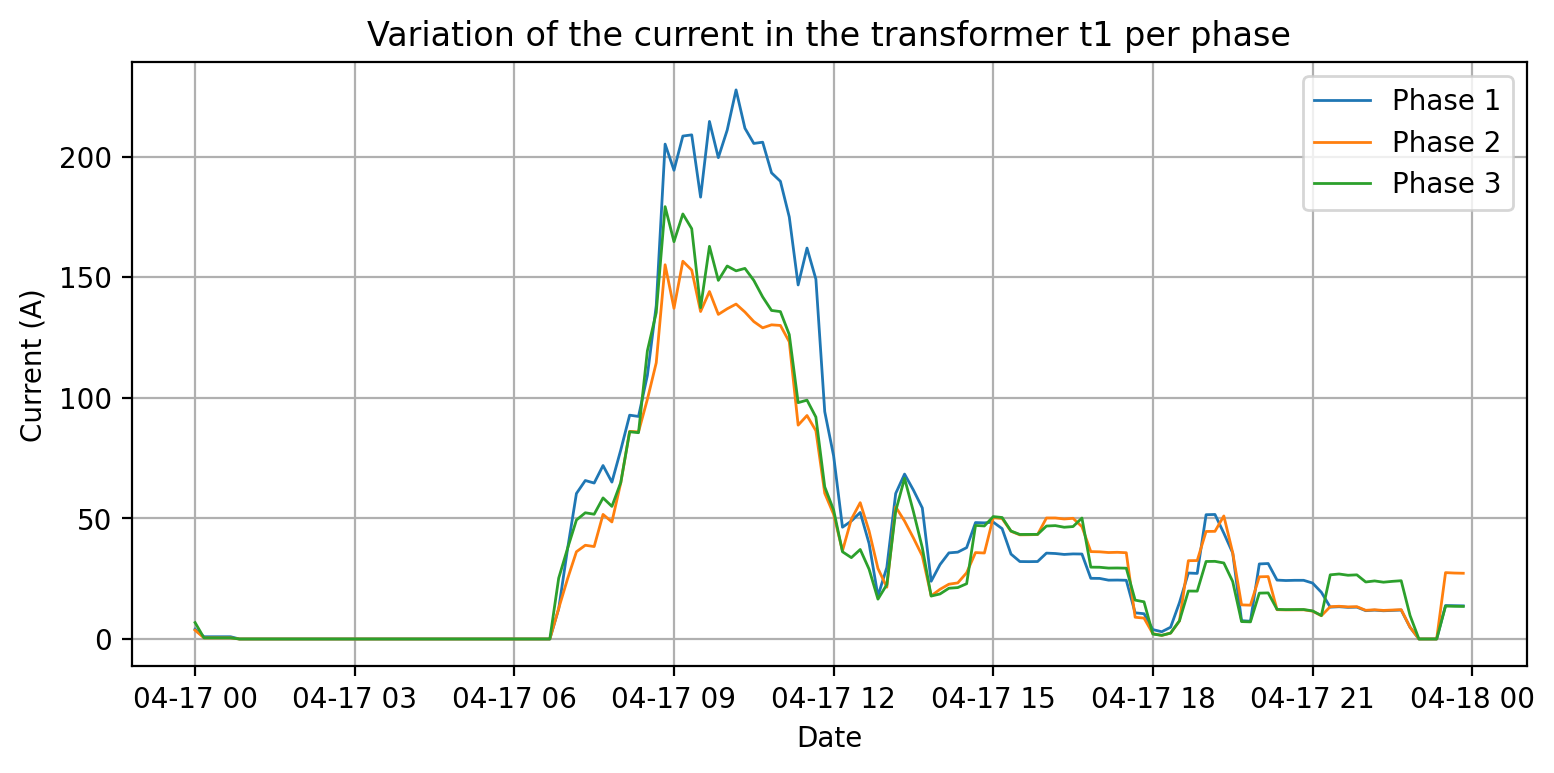

In [4]:
figure(figsize=(9, 4), dpi=200)
plt.plot(dates, result["P1 (kW)"][b:e] * 1000 / 120, linewidth=1, label = "Phase 1")
plt.plot(dates, result["P2 (kW)"][b:e] * 1000 / 120, linewidth=1, label = "Phase 2")
plt.plot(dates, result["P3 (kW)"][b:e] * 1000 / 120, linewidth=1, label = "Phase 3")
plt.xlabel("Date")
plt.ylabel("Current (A)")
plt.title("Variation of the current in the transformer t1 per phase")
plt.grid()
plt.legend()
plt.show()

### 2.6. Plotting the lines losses

There is five types of lines used in the ACN infrastructure. We would like to see the losses in each type of them, and the total losses. 

In [5]:
losses = pd.read_csv("Lines_losses.csv") #Loading the line losses from the csv file

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [6]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

From (year/month/day/hour/minute):2019/04/17/00/00
To (year/month/day/hour/minute):2019/04/18/00/00


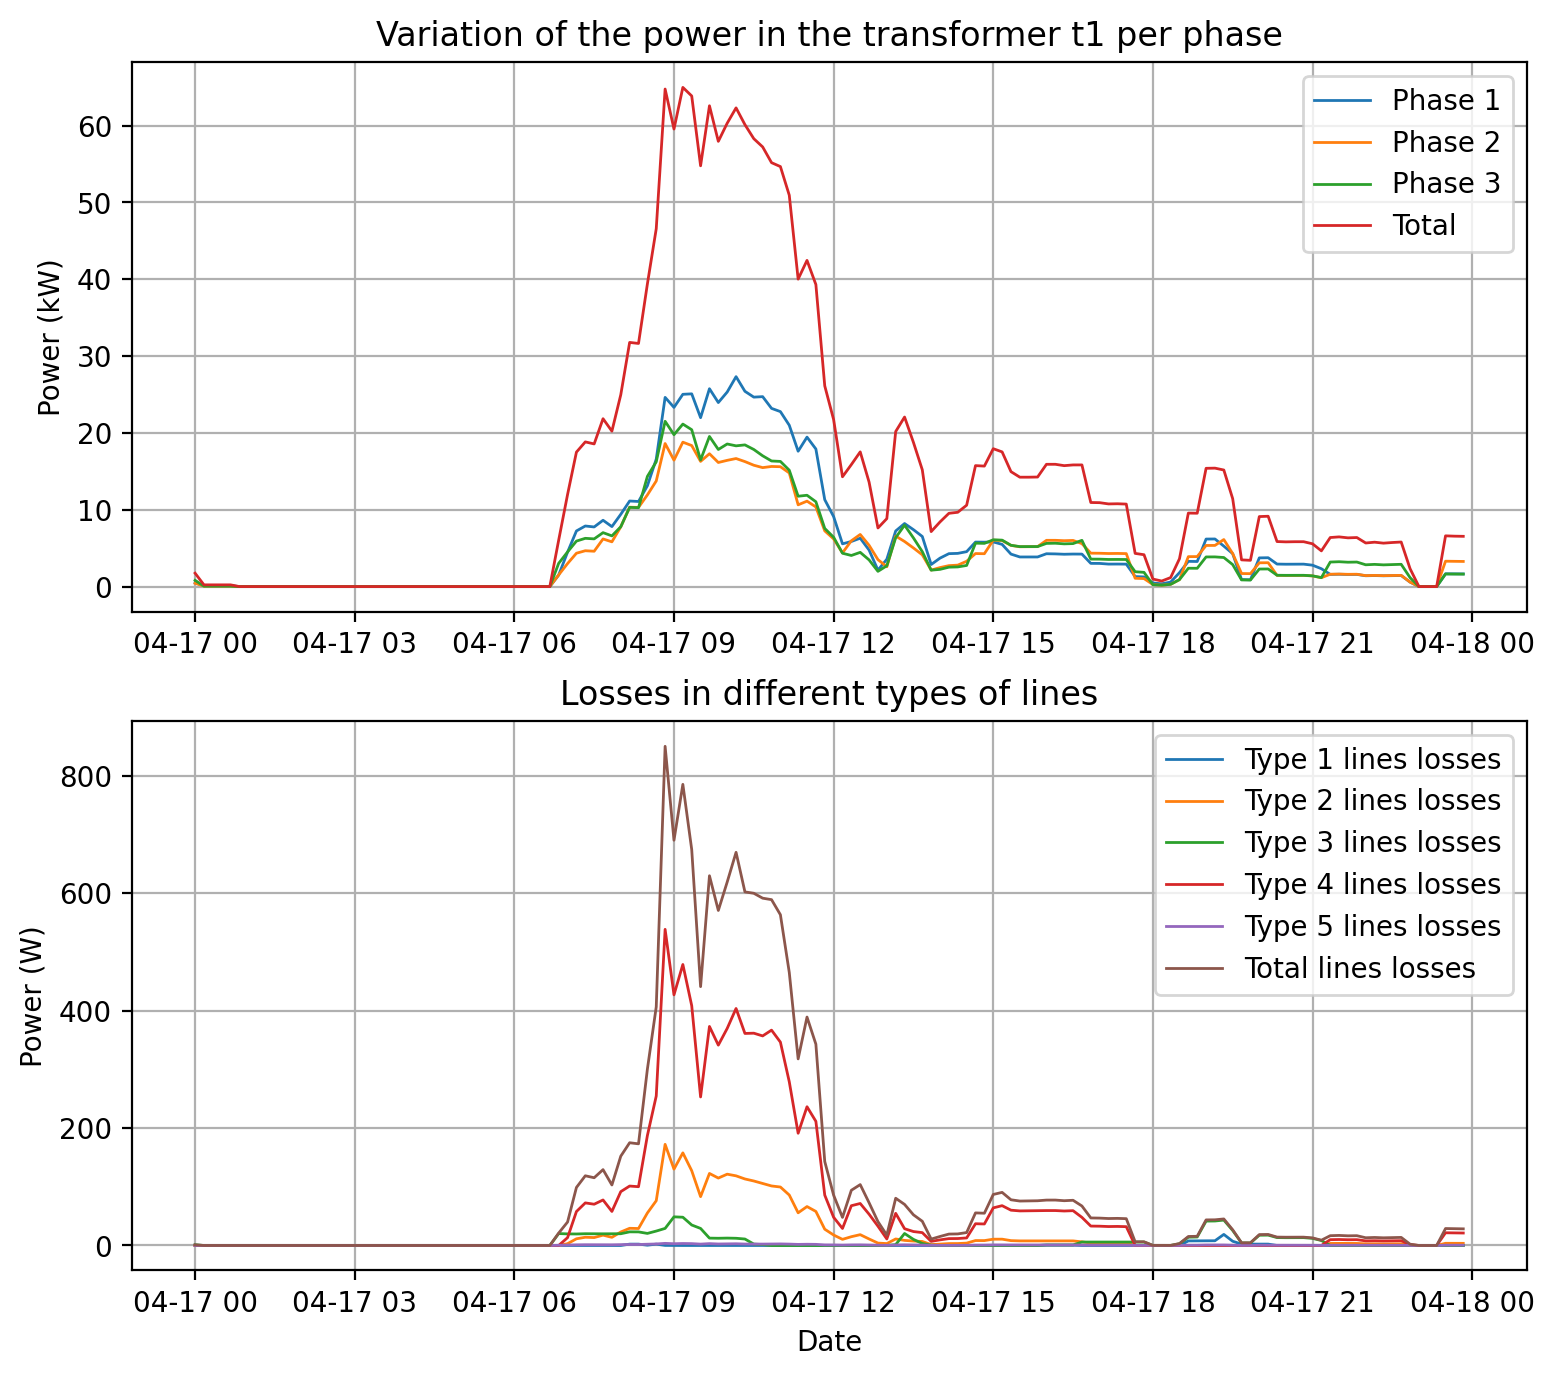

In [7]:
figure(figsize=(9, 8), dpi=200)
######################################################################################################
plt.subplot(2,1,2)
plt.plot(dates,losses["Type 1 lines losses (W)"][b:e], linewidth=1, label = "Type 1 lines losses")
plt.plot(dates,losses["Type 2 lines losses (W)"][b:e], linewidth=1, label = "Type 2 lines losses")
plt.plot(dates,losses["Type 3 lines losses (W)"][b:e], linewidth=1, label = "Type 3 lines losses")
plt.plot(dates,losses["Type 4 lines losses (W)"][b:e], linewidth=1, label = "Type 4 lines losses")
plt.plot(dates,losses["Type 5 lines losses (W)"][b:e], linewidth=1, label = "Type 5 lines losses")
plt.plot(dates,losses["Total lines losses (W)"][b:e], linewidth=1, label = "Total lines losses")
plt.xlabel("Date")
plt.ylabel("Power (W)")
plt.title("Losses in different types of lines")
plt.grid()
plt.legend()
######################################################################################################
plt.subplot(2,1,1)
plt.plot(dates, result["P1 (kW)"][b:e], linewidth=1, label = "Phase 1")
plt.plot(dates, result["P2 (kW)"][b:e], linewidth=1, label = "Phase 2")
plt.plot(dates, result["P3 (kW)"][b:e], linewidth=1, label = "Phase 3")
plt.plot(dates, result["P1 (kW)"][b:e] + result["P2 (kW)"][b:e] + result["P3 (kW)"][b:e], linewidth=1, label = "Total")
plt.ylabel("Power (kW)")
plt.title("Variation of the power in the transformer t1 per phase")
plt.grid()
plt.legend()
######################################################################################################
plt.show()

### 2.7. Plotting the Vrms

The rms value of the voltage is defined as follows:
$$V_{rms} = \sqrt{\frac{V^{2}_{a} + V^{2}_{b} + V^{2}_{c}}{3}}$$
Where:\
$V_{a}$: Line to neutral voltage of the phase one,\
$V_{b}$: Line to neutral voltage of the phase two,\
$V_{c}$: Line to neutral voltage of the phase three.

In [8]:
voltages = pd.read_csv("voltages.csv")

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [6]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

From (year/month/day/hour/minute):2019/04/17/00/00
To (year/month/day/hour/minute):2019/04/18/00/00


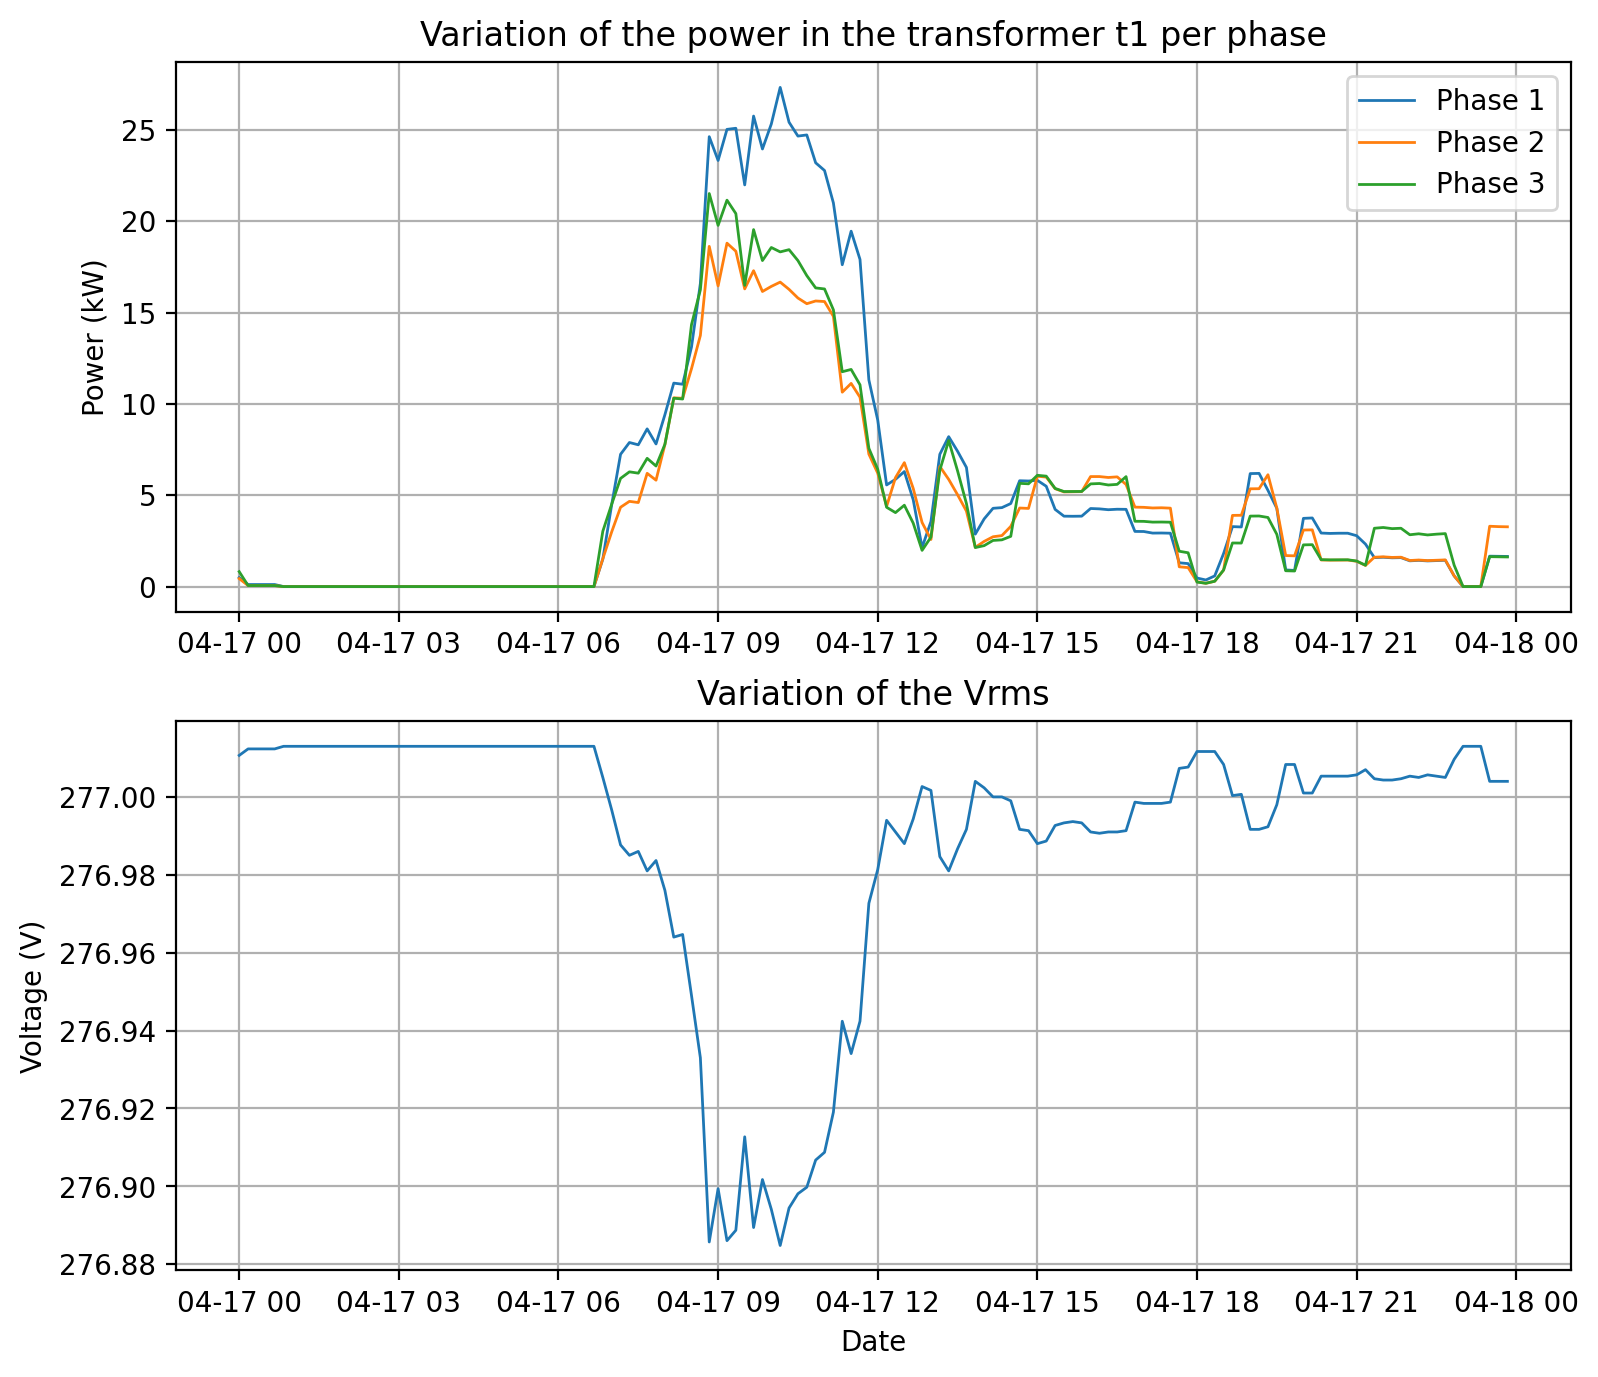

In [9]:
figure(figsize=(9, 8), dpi=200)
#######################################################################################################
plt.subplot(2,1,1)
plt.plot(dates, result["P1 (kW)"][b:e], linewidth=1, label = "Phase 1")
plt.plot(dates, result["P2 (kW)"][b:e], linewidth=1, label = "Phase 2")
plt.plot(dates, result["P3 (kW)"][b:e], linewidth=1, label = "Phase 3")
plt.ylabel("Power (kW)")
plt.title("Variation of the power in the transformer t1 per phase")
plt.grid()
plt.legend()
#######################################################################################################
plt.subplot(2,1,2)
plt.plot(dates, np.sqrt((voltages["V1 (V)"][b:e] ** 2 + voltages["V2 (V)"][b:e] ** 2 + voltages["V3 (V)"][b:e] ** 2) / 3), linewidth=1)
plt.xlabel("Date")
plt.ylabel("Voltage (V)")
plt.title("Variation of the Vrms")
plt.grid()
#######################################################################################################
plt.show()

### 2.8. Plotting the phase angle between voltage phases

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [ ]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

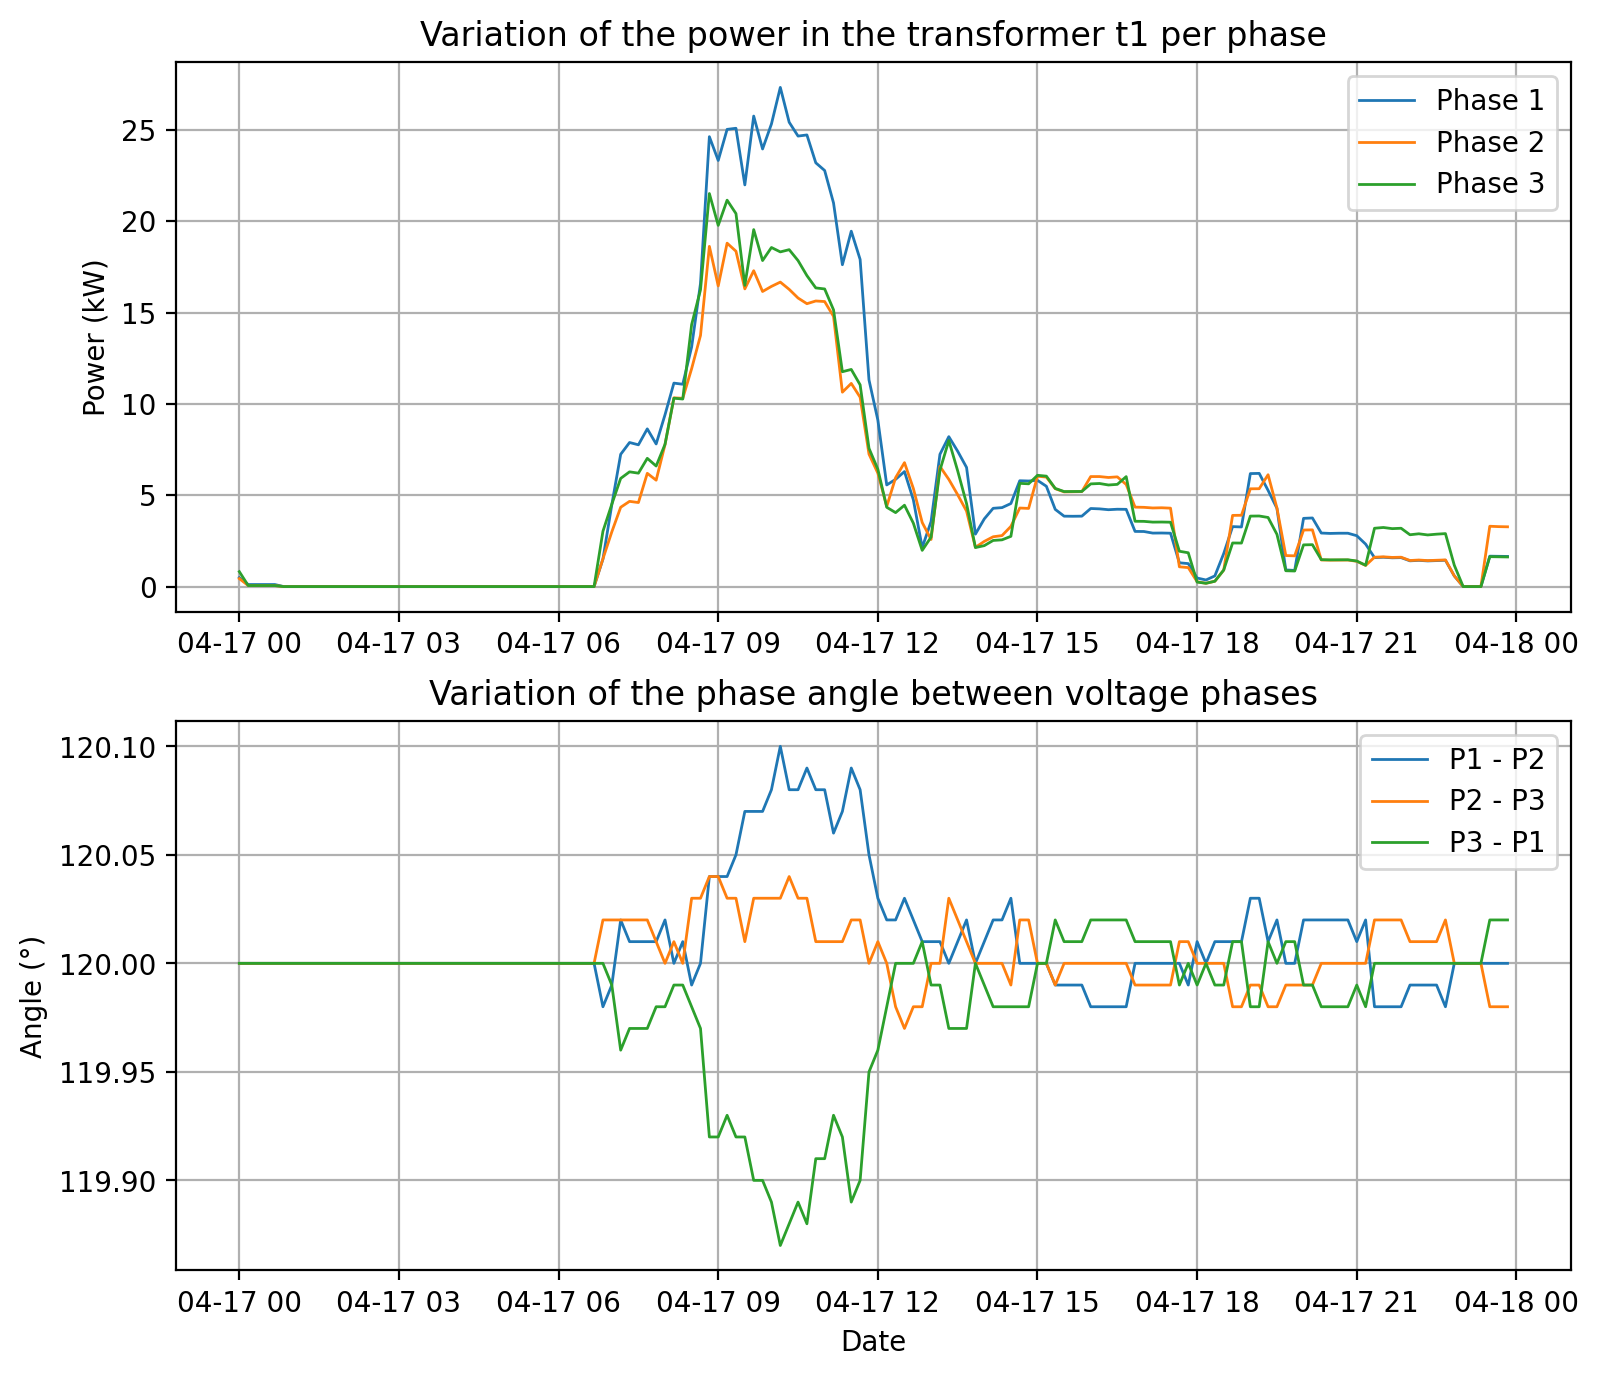

In [10]:
figure(figsize=(9, 8), dpi=200)
#######################################################################################################
plt.subplot(2,1,1)
plt.plot(dates, result["P1 (kW)"][b:e], linewidth=1, label = "Phase 1")
plt.plot(dates, result["P2 (kW)"][b:e], linewidth=1, label = "Phase 2")
plt.plot(dates, result["P3 (kW)"][b:e], linewidth=1, label = "Phase 3")
plt.ylabel("Power (kW)")
plt.title("Variation of the power in the transformer t1 per phase")
plt.grid()
plt.legend()
#######################################################################################################
plt.subplot(2,1,2)
plt.plot(dates, voltages["Ang2 (°)"][b:e] - voltages["Ang1 (°)"][b:e], linewidth=1, label = "P1 - P2")           
plt.plot(dates, 360 + voltages["Ang3 (°)"][b:e] - voltages["Ang2 (°)"][b:e], linewidth=1, label = "P2 - P3")           
plt.plot(dates, voltages["Ang1 (°)"][b:e] - voltages["Ang3 (°)"][b:e], linewidth=1, label = "P3 - P1")           
plt.xlabel("Date")
plt.ylabel("Angle (°)")
plt.title("Variation of the phase angle between voltage phases")
plt.grid()
plt.legend()
#######################################################################################################
plt.show()

### 2.9. Plotting the voltage unbalance factor (VUF)

The Voltage Unbalance Factor ($VUF$) is defined as follows:
$$VUF\ [\%] = \frac{{|\textbf{V}_{n}|}}{|\textbf{V}_{p}|} \times{100},$$
where$\ \textbf{V}_{p} = \frac{\textbf{V}_{a} + a \ . \textbf{V}_{b} + a^{2} \ . \textbf{V}_{c}}{3}$
: Positive sequence voltage phasors,\
$\ \ \ \ \ \ \ \ \ \ \textbf{V}_{n} = \frac{\textbf{V}_{a} + a^{2} \ . \textbf{V}_{b} + a \ . \textbf{V}_{c}}{3}$
: Negative sequence voltage phasors.\
and $\textbf{V}_{a} = V_{a} \ \angle \ \theta_{a}$
    : Line to neutral voltage phasor of the phase one,\
    $\ \ \ \ \ \ \ \textbf{V}_{b} = V_{b} \ \angle \ \theta_{a}$
    : Line to neutral voltage phasor of the phase two,\
    $\ \ \ \ \ \ \ \textbf{V}_{c} = V_{c} \ \angle \ \theta_{a}$ 
    : Line to neutral voltage phasor of the phase three.

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [66]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

From (year/month/day/hour/minute):2019/04/17/00/00
To (year/month/day/hour/minute):2019/04/18/00/00


In [11]:
Va = np.zeros((e-b), dtype=complex)
Vb = np.zeros((e-b), dtype=complex)
Vc = np.zeros((e-b), dtype=complex)
for i in range(e-b):
    r1 = voltages["V1 (V)"][b+i]
    r2 = voltages["V2 (V)"][b+i]
    r3 = voltages["V3 (V)"][b+i]
    t1 = math.radians(voltages["Ang1 (°)"][b+i])
    t2 = math.radians(voltages["Ang2 (°)"][b+i])
    t3 = math.radians(voltages["Ang3 (°)"][b+i])
    Va[i] = complex(r1 * np.cos(t1), r1 * np.sin(t1))
    Vb[i] = complex(r2 * np.cos(t2), r2 * np.sin(t2))
    Vc[i] = complex(r3 * np.cos(t3), r3 * np.sin(t3))
a = np.array([complex(-0.5,np.sqrt(3)/2)])
Vp = (Va + a * Vb + a ** 2 * Vc) / 3
Vn = (Va + a ** 2 * Vb + a * Vc) / 3
VUF = np.absolute(Vn) / np.absolute(Vp) * 100

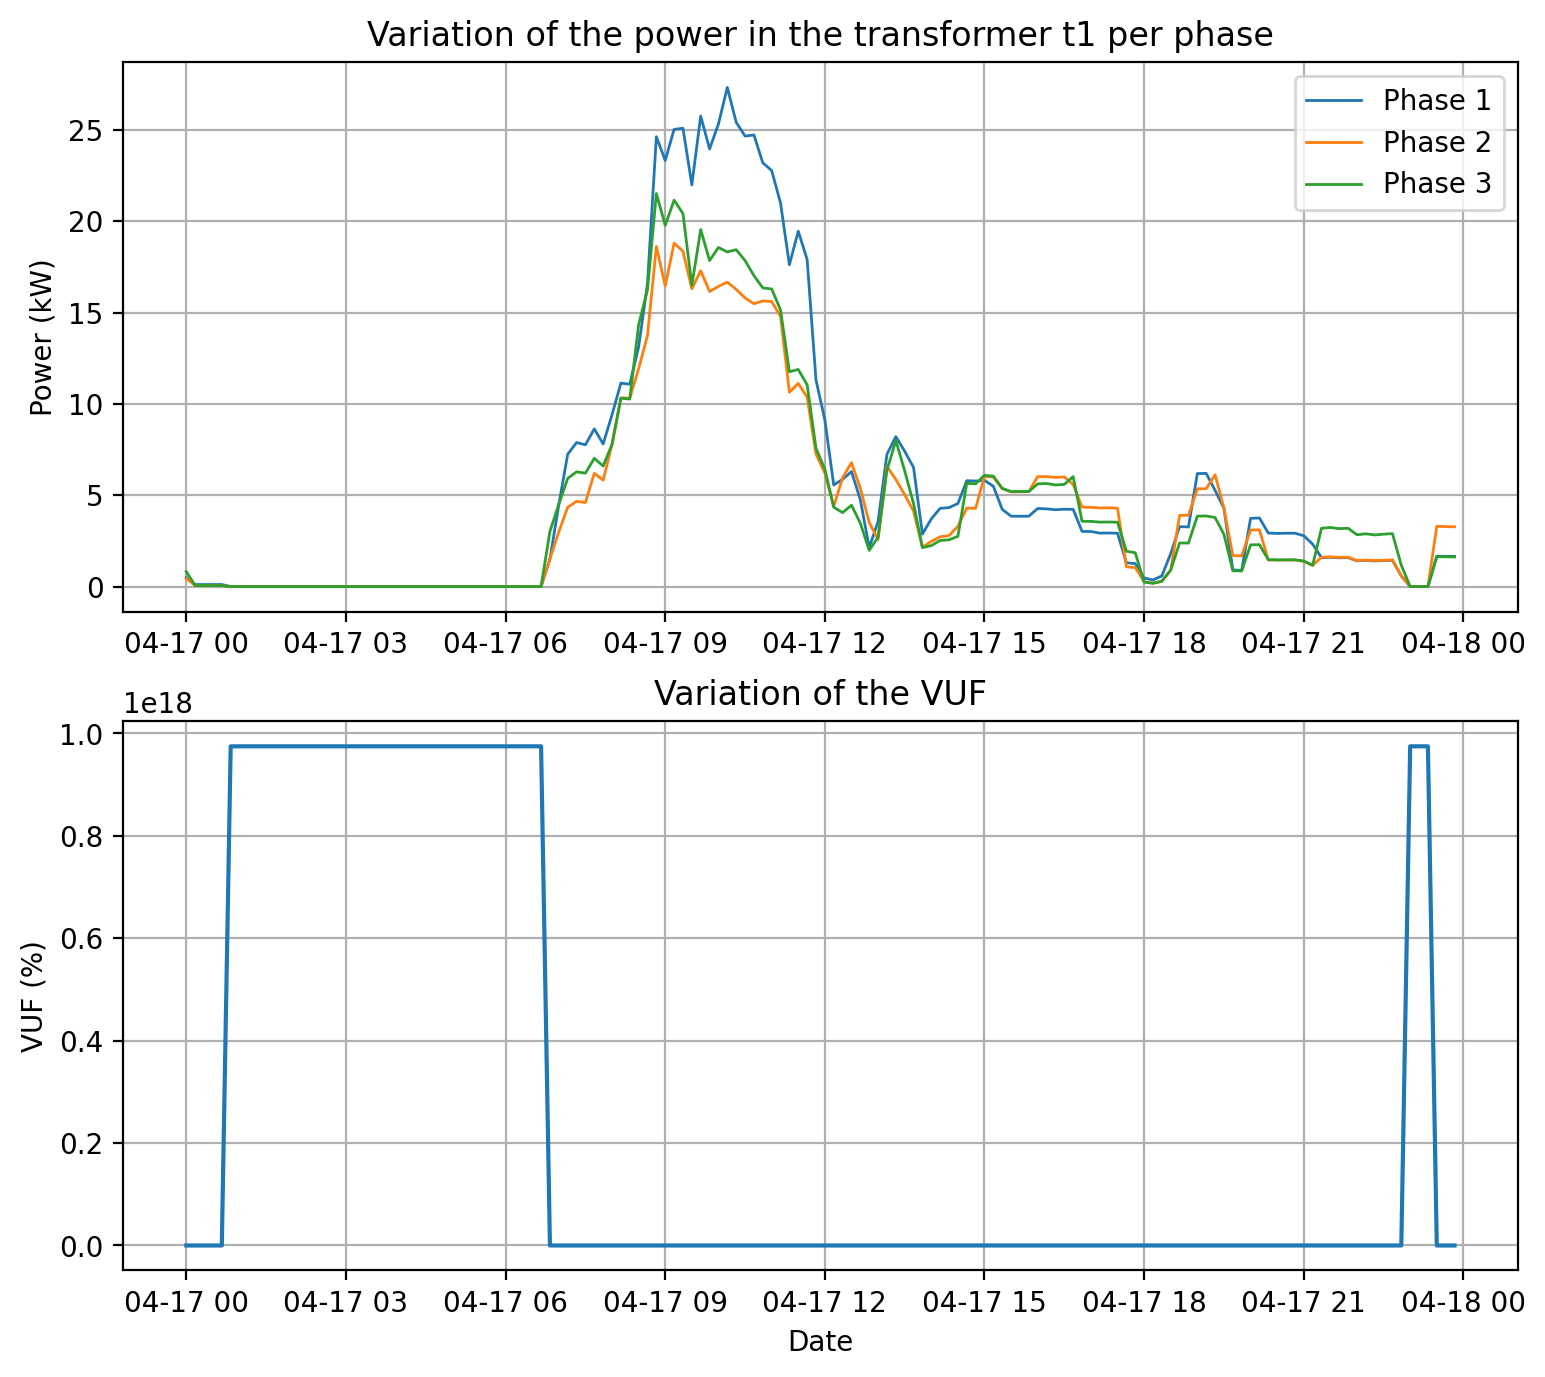

In [12]:
figure(figsize=(9, 8), dpi=200)
#######################################################################################################
plt.subplot(2,1,1)
plt.plot(dates, result["P1 (kW)"][b:e], linewidth=1, label = "Phase 1")
plt.plot(dates, result["P2 (kW)"][b:e], linewidth=1, label = "Phase 2")
plt.plot(dates, result["P3 (kW)"][b:e], linewidth=1, label = "Phase 3")
plt.ylabel("Power (kW)")
plt.title("Variation of the power in the transformer t1 per phase")
plt.grid()
plt.legend()
#######################################################################################################
plt.subplot(2,1,2)
plt.plot(dates, VUF, label="Vp")
plt.xlabel("Date")
plt.ylabel("VUF (%)")
#plt.ylim([0, 2000000])
plt.title("Variation of the VUF")
plt.grid()
#######################################################################################################
plt.show()

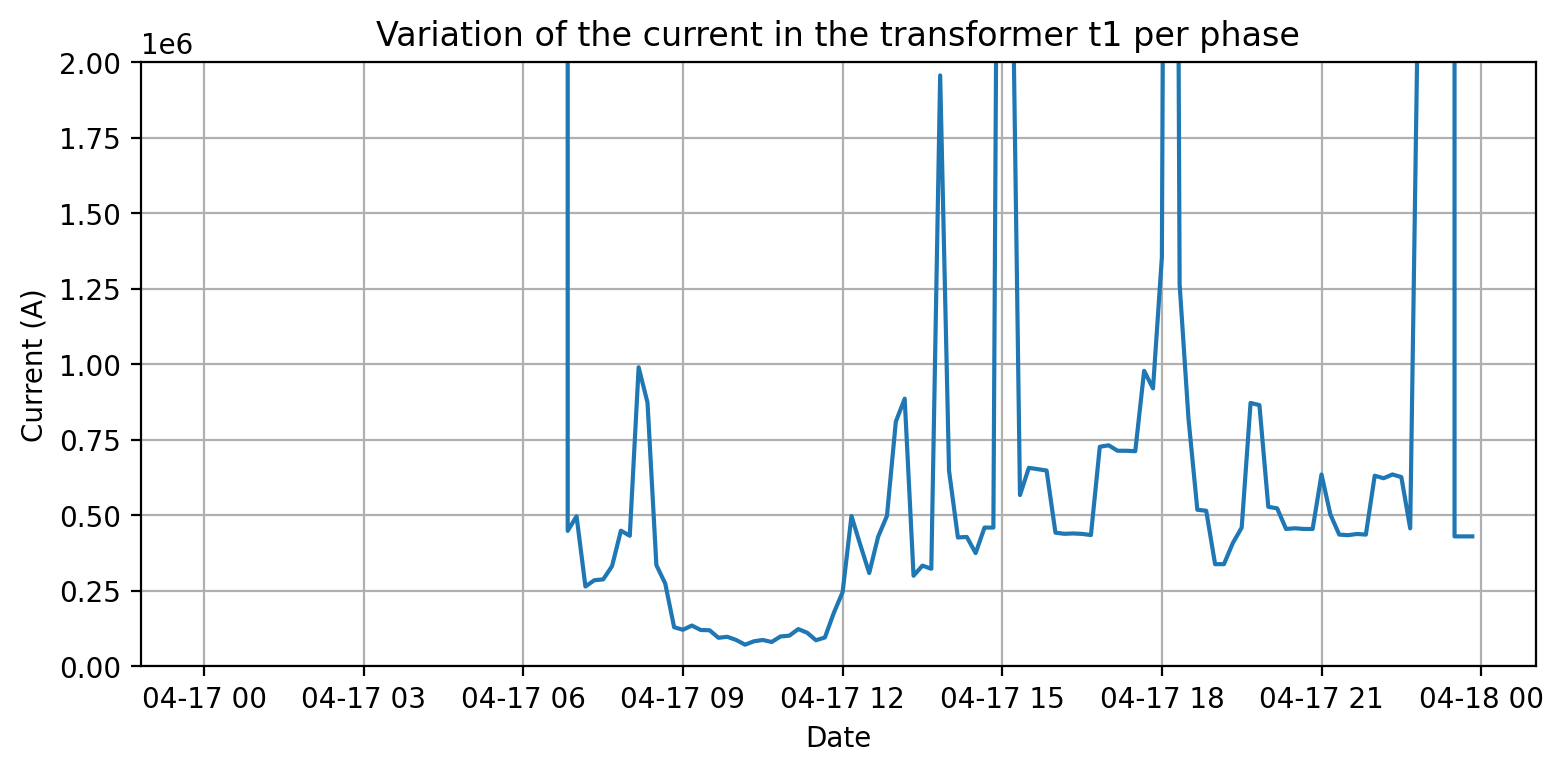

In [13]:
figure(figsize=(9, 4), dpi=200)
plt.plot(dates, VUF)
plt.xlabel("Date")
plt.ylim([0, 2000000])
plt.ylabel("Current (A)")
plt.title("Variation of the current in the transformer t1 per phase")
plt.grid()
plt.show()

In [34]:
r1 = 277
r2 = 277
r3 = 277
ra = 1
t1 = math.radians(0)
t2 = math.radians(310)
t3 = math.radians(-120)
ta = math.radians(120)
Va = complex(r1 * math.cos(t1), r1 * math.sin(t1))
Vb = complex(r2 * math.cos(t2), r2 * math.sin(t2))
Vc = complex(r3 * math.cos(t3), r3 * math.sin(t3))
a = complex(ra * math.cos(ta), ra * math.sin(ta))
Vp = (Va + a * Vb + a ** 2 * Vc)/3
Vn = (Va + a ** 2 * Vb + a * Vc)/3
Vpm = np.absolute(Vp)
Vnm = np.absolute(Vn)
VUF = Vnm / Vpm * 100
print(VUF)

51.69352948411364


In [94]:
Va[i] = complex(r1 * np.cos(t1), r1 * np.sin(t1))

In [93]:
Va = np.zeros((e-b), dtype=complex)

In [35]:
n1 = np.array([1, 2, 3])

In [36]:
n2 = np.array([1, 2, 3])

In [71]:
n3 = np.zeros((e-b))

In [73]:
n3.shape

(144,)

In [68]:
n1 * a**2

array([-0.5-0.8660254j , -1. -1.73205081j, -1.5-2.59807621j])

In [77]:
r1 = np.array(voltages["V1 (V)"][b:e])
r2 = np.array(voltages["V2 (V)"][b:e])
r3 = np.array(voltages["V3 (V)"][b:e])
ra = 1
t1 = np.array(np.radians(voltages["Ang1 (°)"][b:e]))
t2 = np.array(np.radians(voltages["Ang2 (°)"][b:e]))
t3 = np.array(np.radians(voltages["Ang3 (°)"][b:e]))
ta = math.radians(120)
V1 = np.array(r1 * np.cos(t1) + r1 * np.sin(t1)j,dtype=np.complex_)
V3 = np.array(r2 * np.cos(t2) + r2 * np.sin(t2)j,dtype=np.complex_)
V2 = np.array(r3 * np.cos(t3) + r3 * np.sin(t3)j,dtype=np.complex_)
a = -0.5 + math.sqrt(3) / 2j
Vp = (V1 + a * V2 + a ** 2 * V3)/3
Vn = (V1 + a ** 2 * V2 + a * V3)/3
Vpm,_ = cmath.polar(Vp)
Vnm,_ = cmath.polar(Vn)
VUF = Vnm / Vpm * 100
print(VUF)

SyntaxError: invalid syntax (Temp/ipykernel_8324/2822922927.py, line 9)

In [54]:
r1 = np.array(voltages["V1 (V)"][b:e])

In [55]:
t1 = np.array(np.radians(voltages["Ang1 (°)"][b:e]))

In [69]:
float(r1[0]) * math.cos(float(t1[0])) + float(r1[0]) * math.sin(float(t1[0]))j

SyntaxError: invalid syntax (Temp/ipykernel_8324/2961838965.py, line 1)

In [70]:
type(float(r1[0]) * math.cos(float(t1[0])))

float

In [73]:
a = 1

In [74]:
b = 2

In [75]:
a + bj

NameError: name 'bj' is not defined

In [49]:
voltages["V1 (V)"][b+60]

276.844

In [50]:
voltages["V2 (V)"][b+60]

276.752

In [28]:
voltages["V3 (V)"][b+60]

277.154

In [29]:
voltages["Ang1 (°)"][b+60]

-0.26

In [30]:
voltages["Ang2 (°)"][b+60]

-120.18

In [31]:
voltages["Ang3 (°)"][b+60]

119.8

In [36]:
b

15264

In [45]:
result["P1 (kW)"][b] + result["P2 (kW)"][b] + result["P3 (kW)"][b]

1.354

In [41]:
data[file[3:9].lower()].iloc[b]

0    0.0
Name: 15264, dtype: float64

In [42]:
s = 0
for file in file_list:
    s = s + data[file[3:9].lower()].iloc[b]

In [43]:
print(s)

0    1352.0
Name: 15264, dtype: float64


### 2.10. Plotting the phase unbalance index (PUI)

The phase unbalance index is defined as follows:
$$PUI = \frac{Max(|I_{a} - I_{avg}|, |I_{b} - I_{avg}|, |I_{c} - I_{avg}|)}{I_{avg}} \times{100},$$
where $I_{a}$: Current in phase one,\
$\ \ \ \ \ \ \ \ \ \ I_{b}$: Current in phase two,\
$\ \ \ \ \ \ \ \ \ \ I_{b}$: Current in phase three,\
$\ \ \ \ \ \ \ \ \ \ I_{avg}$: Average value of the current.

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results.

In [58]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

From (year/month/day/hour/minute):2019/04/17/00/00
To (year/month/day/hour/minute):2019/04/18/00/00


C:\Users\lazhe\AppData\Local\Temp/ipykernel_12724/782829669.py:18: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  plt.plot(dates, pd.concat([abs(I_a - I_avg), abs(I_b - I_avg), abs(I_c - I_avg)]).max(level=0) / I_avg * 100, linewidth=1)


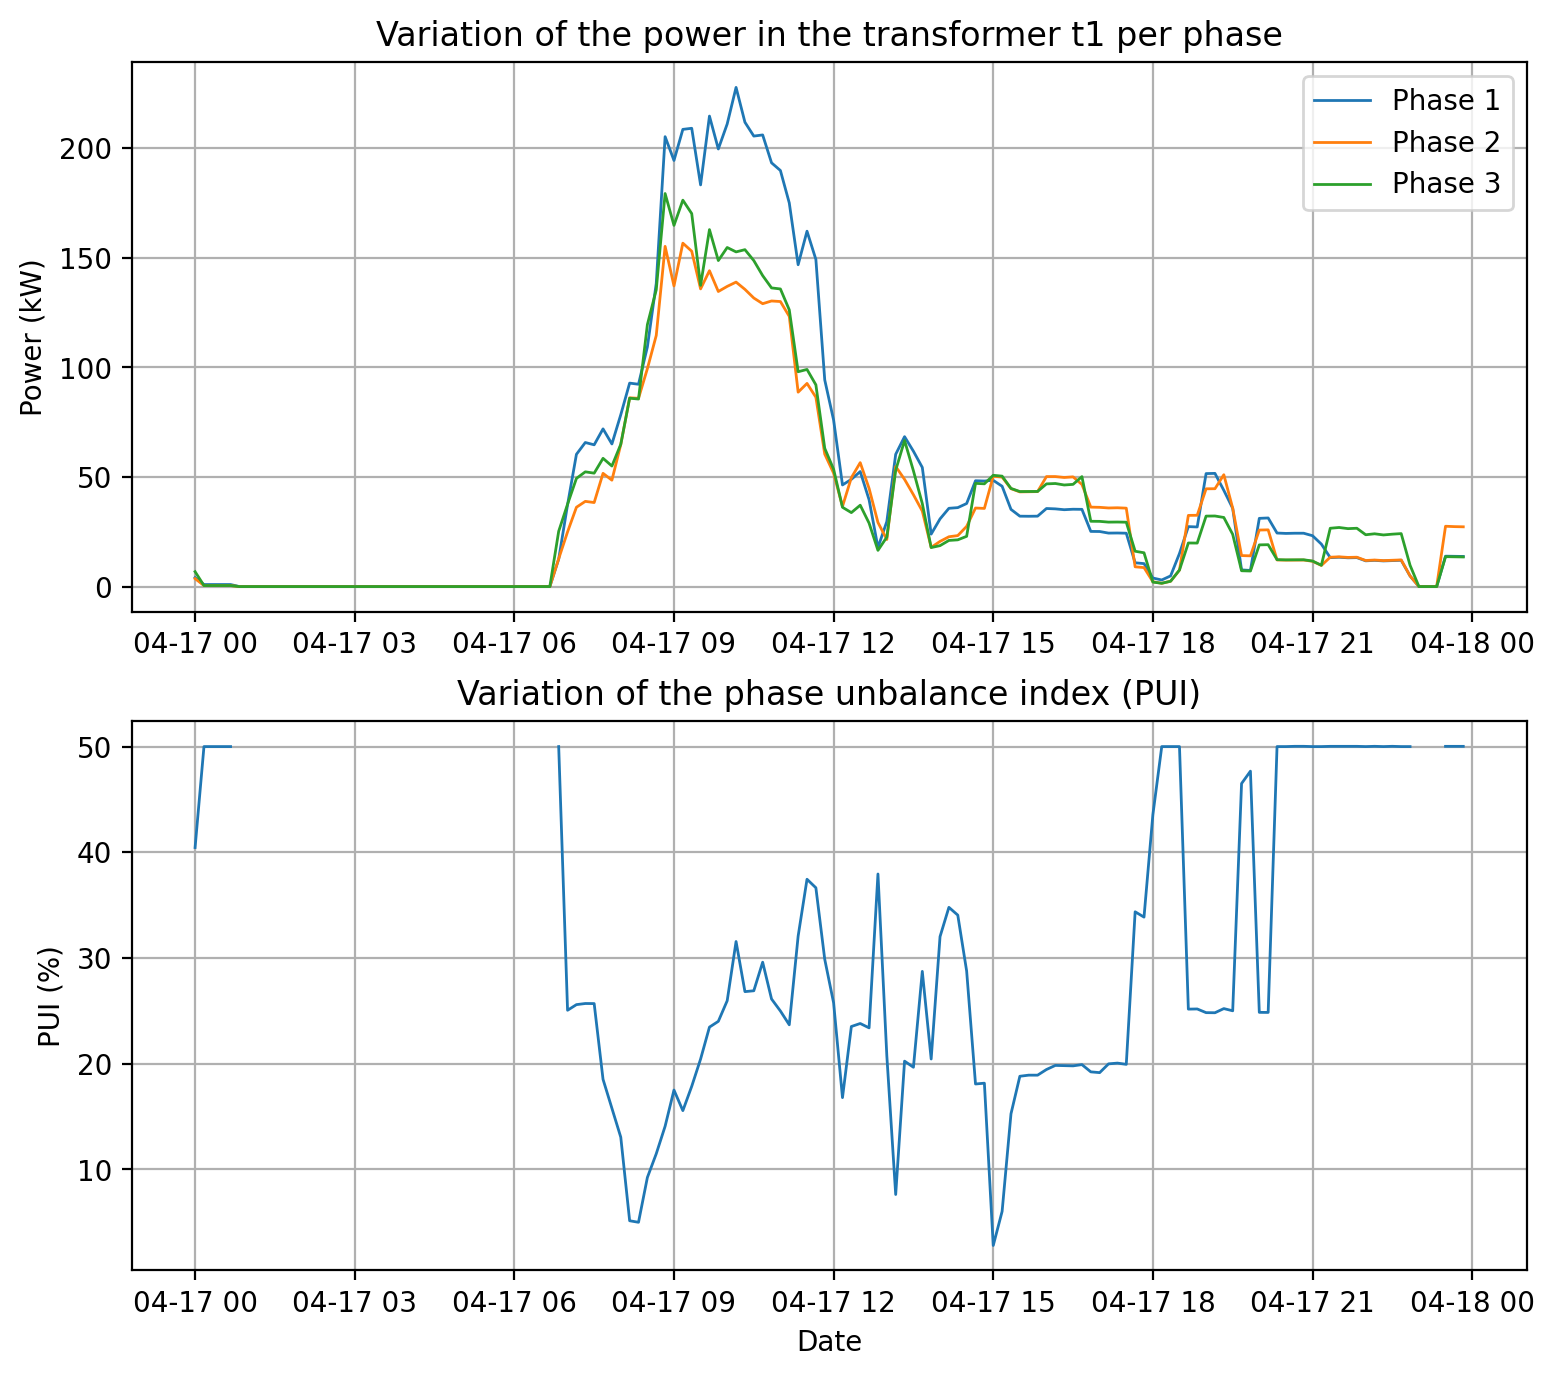

In [19]:
figure(figsize=(9, 8), dpi=200)
#######################################################################################################
plt.subplot(2,1,1)
I_a = result["P1 (kW)"][b:e] * 1000 / 120
I_b = result["P2 (kW)"][b:e] * 1000 / 120
I_c = result["P3 (kW)"][b:e] * 1000 / 120
plt.plot(dates, I_a, linewidth=1, label = "Phase 1")
plt.plot(dates, I_b, linewidth=1, label = "Phase 2")
plt.plot(dates, I_c, linewidth=1, label = "Phase 3")
plt.ylabel("Power (kW)")
plt.title("Variation of the power in the transformer t1 per phase")
plt.grid()
plt.legend()
#######################################################################################################
plt.subplot(2,1,2)

I_avg = (I_a + I_b + I_c) / 3 
plt.plot(dates, pd.concat([abs(I_a - I_avg), abs(I_b - I_avg), abs(I_c - I_avg)]).max(level=0) / I_avg * 100, linewidth=1)
#plt.plot(dates, I_avg , linewidth=1)
plt.xlabel("Date")
plt.ylabel("PUI (%)")
plt.title("Variation of the phase unbalance index (PUI)")
plt.grid()
#######################################################################################################
plt.show()

In [ ]:
pd.m